In [1]:
import numpy as np
from pyrex.main import *
from pyrex.core import *
import sxs
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime), delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime), delta_t=deltaT)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm,samplerate, f_higher = None):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    # cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower, high_frequency_cutoff = f_higher)
    htilde = make_frequency_series(nrdt)    
    stilde = make_frequency_series(mdt)
    h_imag=make_frequency_series(nid)*1j
    s_im=make_frequency_series(mdi)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im
    cmatch=match(htilde, stilde,psd=psd,low_frequency_cutoff=f_lower, high_frequency_cutoff = f_higher)
    return cmatch #cmatch[0]

In [58]:
sims = ['SXS:BBH:1358', 'SXS:BBH:1365', 'SXS:BBH:1372', 'SXS:BBH:1359', 'SXS:BBH:1366', 'SXS:BBH:1360', 'SXS:BBH:1367', 'SXS:BBH:1361']
eccentricities = [0.099, 0.06, 0.092, 0.1, 0.095, 0.142, 0.096, 0.144] # These come from a fit
xs = [np.float64(0.14139682985076596), np.float64(0.132758281522539), np.float64(0.11027495434452218), np.float64(0.11961646851279063), np.float64(0.12375690560387184), np.float64(0.14293288752385297), np.float64(0.13819894720860718), np.float64(0.12596736778632023)] # Made if using Glassware class using find_x
masses = np.linspace(25, 150, 14)
distance, inclination, coa_phase = 1, 0, 0
mismatches = {}
for s, eccentricity, x in zip(sims, eccentricities, xs):
    sim = sxs.load(s, ignore_deprecation=True, extrapolation="Outer")
    
    q = sim.metadata["reference_mass_ratio"]
    # eccentricity = sim.metadata["reference_eccentricity"]
    spin1x, spin1z, spin1y = 0, 0, 0
    spin2x, spin2z, spin2y = 0, 0, 0

    mismatch_seob, mismatch_phen = [], []
    for total_mass in masses:
        if q < 1:
            q = 1/q
        mass1 = q * total_mass / (q + 1)
        mass2 = total_mass / (q + 1)
        std_phenom = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'IMRPhenomD','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}
        std_seob = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'SEOBNRv4','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}

        phen_ecc = Cookware(**std_phenom)
        seob_ecc = Cookware(**std_seob)

        scale = NR_amp_scale(total_mass, distance)
        y22 = find_Y22(inclination, coa_phase)

        t0 = sim.h.t[np.argmax(sim.h[:, sim.h.index(2, 2)])]
        t_ref = (sim.h.t - t0) * (total_mass * lal.MTSUN_SI)
        t_start = t_ref[0]
        t_end = -29 * (total_mass * lal.MTSUN_SI)
        
        t_seob = seob_ecc.time
        t_phen = phen_ecc.time

        # mask_ref = t_ref <= t_end/
        mask_seob = (t_seob >= t_start)# & (t_seob <= t_end)
        mask_phen = (t_phen >= t_start)# & (t_phen <= t_end)

        # print(len(t_ref[mask_ref]))
        # print(len(sim.h[:, sim.h.index(2, 2)][mask_ref]))

        mismatch_phen.append(1 - compute_match(t_phen, phen_ecc.h22 / (scale * y22), t_ref, sim.h[:, sim.h.index(2, 2)].ndarray * (scale * y22), t_seob, 16384, f_higher = (1/(6**(3/2)*np.pi*total_mass * lal.MTSUN_SI)))[0])
        mismatch_seob.append(1 - compute_match(t_seob, seob_ecc.h22 / (scale * y22), t_ref, sim.h[:, sim.h.index(2, 2)].ndarray * (scale * y22), t_seob, 16384, f_higher = (1/(6**(3/2)*np.pi*total_mass * lal.MTSUN_SI)))[0])
    mismatches[eccentricity] = (mismatch_phen, mismatch_seob)


(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning)>> This version has only been calibrated up to q<=3.
(warning

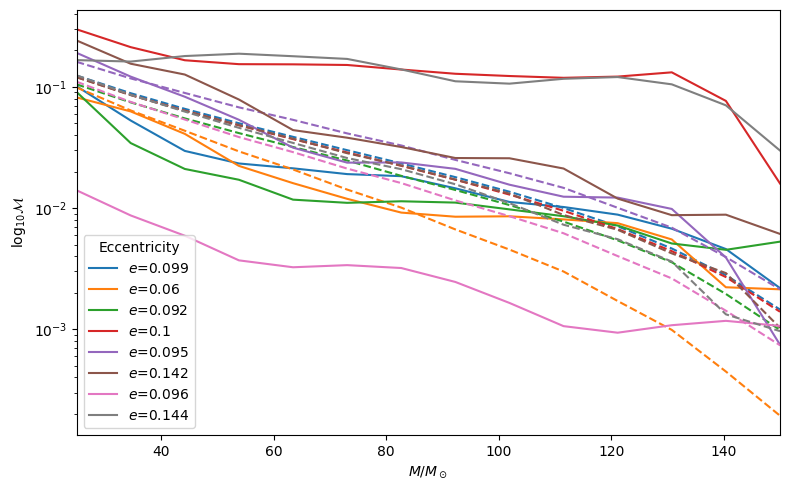

In [59]:
linestyles = {
    "SEOB": "--",
    "Phenom": "-"
}
plt.figure(figsize=(8, 5))
legend_handles = []
for eccentricity, (mismatch_phen, mismatch_seob) in mismatches.items():
    line_phen, = plt.plot(masses, mismatch_phen, linestyle=linestyles["Phenom"])
    plt.plot(masses, mismatch_seob, linestyle=linestyles["SEOB"], color=line_phen.get_color())
    legend_handles.append((line_phen, fr"$e$={eccentricity}"))

plt.legend(*zip(*legend_handles), title="Eccentricity")
plt.yscale("log")
plt.xlim(25, 150)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\text{log}_{10} \mathcal{M}$")
plt.tight_layout()
plt.show()


In [ ]:
q = 1
eccentricity = 0
spin1x, spin1z, spin1y = 0, 0, 0
spin2x, spin2z, spin2y = 0, 0, 0

masses = [50]
for total_mass in masses:
    if q < 1:
        q = 1/q
    mass1 = q * total_mass / (q + 1)
    mass2 = total_mass / (q + 1)
    std_phenom = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'IMRPhenomD','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}
    std_seob = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'SEOBNRv4','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin1y,'spin2z':spin1z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}

    phen_ecc = Cookware(**std_phenom)
    seob_ecc = Cookware(**std_seob)

    scale = NR_amp_scale(total_mass, distance)
    y22 = find_Y22(inclination, coa_phase)

    t0 = sim.h.t[np.argmax(sim.h[:, sim.h.index(2, 2)])]
    t_ref = (sim.h.t - t0) * (total_mass * lal.MTSUN_SI)
    t_start = t_ref[0]
    t_end = -29 * (total_mass * lal.MTSUN_SI)
    
    t_seob = seob_ecc.time
    t_phen = phen_ecc.time

    # mask_ref = t_ref <= t_end/
    mask_seob = (t_seob >= t_start)# & (t_seob <= t_end)
    mask_phen = (t_phen >= t_start)# & (t_phen <= t_end)


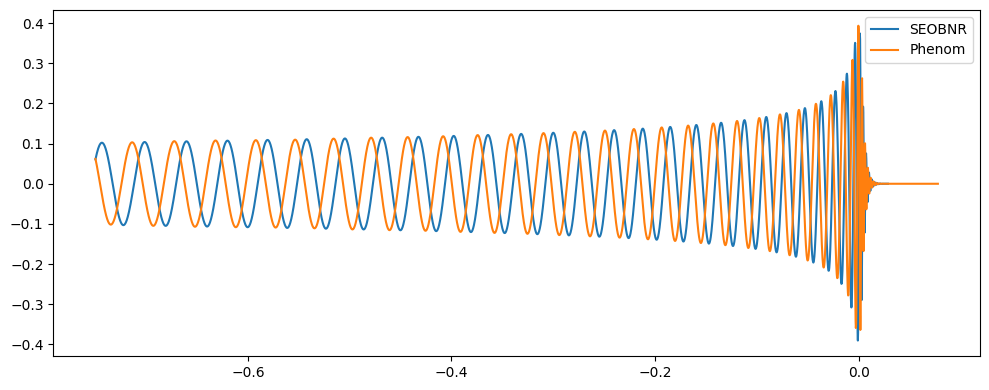

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(t_seob[mask_seob], seob_ecc.h22[mask_seob] / (scale * y22), label="SEOBNR")
plt.plot(t_phen[mask_phen], phen_ecc.h22[mask_phen] / (scale * y22), label="Phenom")
# plt.plot(t_ref, sim.h[:, sim.h.index(2, 2)], label="NR simulation")

plt.legend()
plt.tight_layout()
plt.show()